# PyroadAcoustics dynamic sine wave

In [2]:
import pyroadacoustics as pyroad

import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from scipy.io import wavfile
import os
import IPython.display as ipd
import struct

In [3]:
# Sampling Frequency
fs = 48_000

# Atmospheric Parameters
T = 20
p = 1
h_rel = 50

env = pyroad.Environment(fs = fs, temperature = T, pressure = p, rel_humidity = h_rel)

# Define source signal
t = np.arange(0,8,1/fs)
  
# Sin signal
amplitude = 1.0
frequency = 2_000
duration = 8.0
time = np.linspace(0, duration, int(fs * duration))
x = amplitude * np.sin(2 * np.pi * frequency * time)

# Add moving source
env.add_source(position = np.array([173,3,1]), signal=x, trajectory_points=np.array([[173,3,1], [171.5,3,1], [-171.5,3,1]]), source_velocity=np.array([0.5, 49]))

# Add microphone array
mic_array = np.array([[0,0,1], ])
env.add_microphone_array(mic_array)

interp_method = "Sinc"#  "Linear" "Allpass" "Sinc"
include_reflection = False
include_air_absorption = True

env.set_simulation_params(interp_method, include_reflection, include_air_absorption)

# Run simulation 
signal = env.simulate()

# Save Audio File
os.makedirs("_tmp", exist_ok=True)
interleaved = (np.clip(signal, -1.0, 1.0) * np.iinfo(np.int32).max).astype(np.int32).reshape(-1)
wavfile.write('_tmp/pyroad_sine_dynamic.wav', fs, interleaved) # int32 (little-endian)

0.29892555


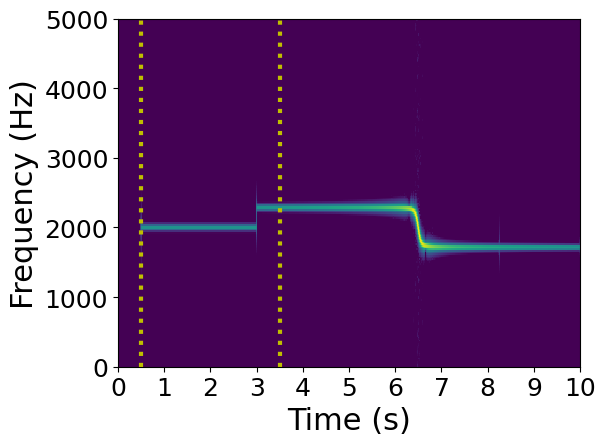

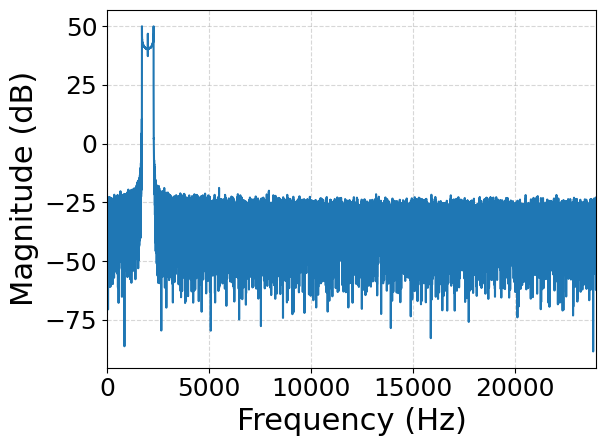

In [15]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


signal, sr = librosa.load("_tmp/pyroad_sine_dynamic.wav", sr=None, mono=False)

if signal.ndim == 1:  # if single channel reshape to a common format (n_channels, n_samples)
    signal = signal.reshape(1, -1)

print(max(signal[0]))
ipd.display(ipd.Audio(signal[0], rate=sr))

D = librosa.stft(signal[0])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure()
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='fft', cmap='viridis')#, vmin=-30, vmax=-0)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 5_000)
plt.xlim(0, 10)
plt.axvline(3.5, color='y', linestyle=':', linewidth=3)
plt.axvline(0.5, color='y', linestyle=':', linewidth=3)
# plt.colorbar(format='%+2.0f dB')
#plt.title('Spectrogram')
plt.tight_layout()
plt.savefig("_tmp/sine_dynamic_spectrogram_pyroad.png", dpi=300)
plt.show()

# --- FFT ---
X = np.fft.rfft(signal[0])
N = len(signal[0])
freq = np.fft.rfftfreq(N, d=1/sr)

# magnitude to dB
mag = np.abs(X)
mag_db = 20 * np.log10(mag + 1e-12)

plt.figure()
plt.plot(freq, mag_db, color='C0')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#plt.title('Single-sided FFT of the signal (unnormalized amplitude)')
plt.xlim(0, sr / 2)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("_tmp/sine_dynamic_fft_pyroad.png", dpi=300)
plt.show()

# DynamicSound dynamic sine wave

In [5]:
import os
import dynamic_sound as ds
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import numpy as np
import pyroomacoustics as pra

In [6]:
source_path = ds.Path([
    [0.0,  173, 3, 1,   1, 0, 0, 0],
    [3.0,  171.5, 3, 1,   1, 0, 0, 0],
    [10.0,  -171.5, 3, 1,   1, 0, 0, 0]
])
microphone_path = ds.Path([
    [0.0,  0, 0, 1,   1, 0, 0, 0],
    [10.0,  0, 0, 1,   1, 0, 0, 0]
])

# simulation environment
sim = ds.Simulation(
    temperature=20,
    pressure=1,
    relative_humidity=50
)

# microphone
mic_sample_rate = 48_000
microphone = ds.microphones.Microphone("_tmp/dynamicsound_sine_dynamic.wav", sample_rate=mic_sample_rate)
sim.add_microphone(path=microphone_path, microphone=microphone)

# source
source = ds.sources.SineWave(frequency=2_000, amplitude=1.0)
sim.add_source(
    path=source_path,
    source=source
)

sim.run()

100%|██████████| 480000/480000 [20:33<00:00, 389.07it/s] 


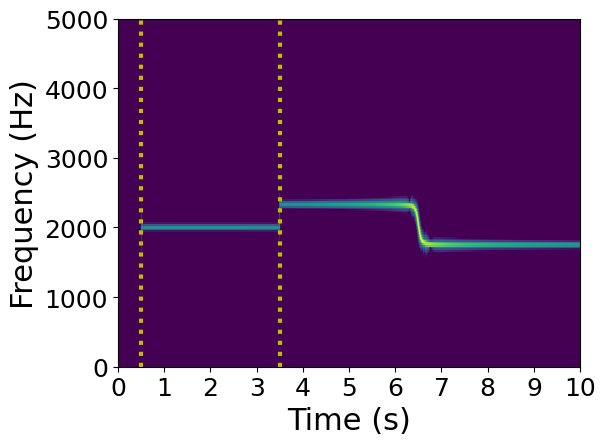

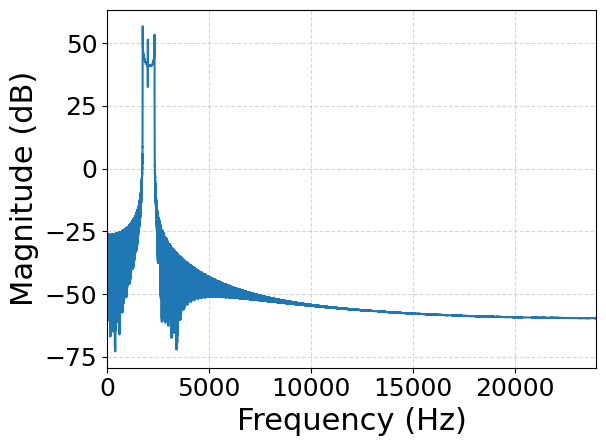

In [16]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


signal, sr = librosa.load("_tmp/dynamicsound_sine_dynamic.wav", sr=None, mono=False)

if signal.ndim == 1:  # if single channel reshape to a common format (n_channels, n_samples)
    signal = signal.reshape(1, -1)
    
ipd.display(ipd.Audio(signal[0], rate=sr))

D = librosa.stft(signal[0])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure()
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='fft', cmap='viridis', vmin=-70, vmax=-0)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 5_000)
plt.xlim(0, 10)
# plt.colorbar(format='%+2.0f dB')
plt.axvline(3.5, color='y', linestyle=':', linewidth=3)
plt.axvline(0.5, color='y', linestyle=':', linewidth=3)
#plt.title('Spectrogram')
plt.tight_layout()
plt.savefig("_tmp/sine_dynamic_spectrogram_dynamicsound.png", dpi=300)
plt.show()

# --- FFT ---
X = np.fft.rfft(signal[0])
N = len(signal[0])
freq = np.fft.rfftfreq(N, d=1/sr)

mag = np.abs(X)
mag_db = 20 * np.log10(mag + 1e-12)

plt.figure()
plt.plot(freq, mag_db, color='C0')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#plt.title('Single-sided FFT of the signal (channel 0)')
plt.xlim(0, sr / 2)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("_tmp/sine_dynamic_fft_dynamicosund.png", dpi=300)
plt.show()


# DynamicSound dynamic microphone array

In [2]:
import os
import dynamic_sound as ds
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import numpy as np
import pyroomacoustics as pra

In [3]:
source_path = ds.Path([
    [0.0,  0, 0, 1,   1, 0, 0, 0],
    [10.0,  0, 0, 1,   1, 0, 0, 0]
])
microphone_path = ds.Path([
    [0.0,  173, 3, 1,   1, 0, 0, 0],
    [3.0,  171.5, 3, 1,   1, 0, 0, 0],
    [10.0,  -171.5, 3, 1,   1, 0, 0, 0]
])

# simulation environment
sim = ds.Simulation(
    temperature=20,
    pressure=1,
    relative_humidity=50
)

# microphone
mic_sample_rate = 48_000
microphone = ds.microphones.Microphone("_tmp/dynamicsound_sine_dynamic_microphone.wav", sample_rate=mic_sample_rate)
sim.add_microphone(path=microphone_path, microphone=microphone)

# source
source = ds.sources.SineWave(frequency=2_000, amplitude=1.0)
sim.add_source(
    path=source_path,
    source=source
)

sim.run()

100%|██████████| 480000/480000 [12:41<00:00, 630.60it/s] 


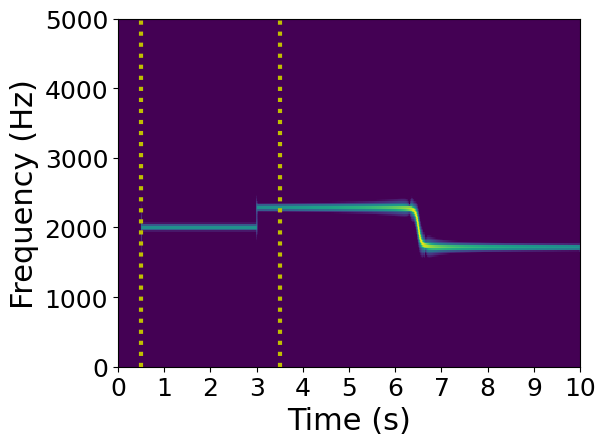

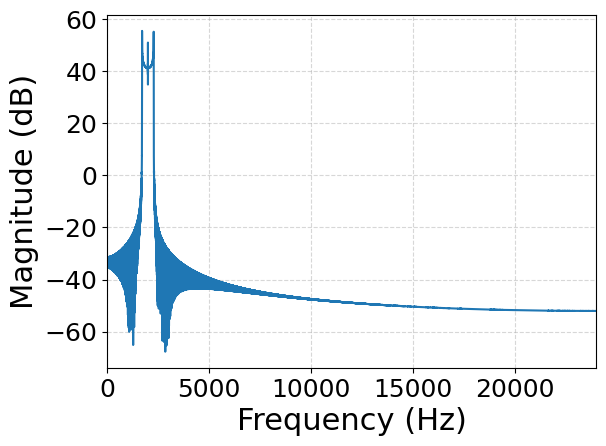

In [17]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


signal, sr = librosa.load("_tmp/dynamicsound_sine_dynamic_microphone.wav", sr=None, mono=False)

if signal.ndim == 1:  # if single channel reshape to a common format (n_channels, n_samples)
    signal = signal.reshape(1, -1)
    
ipd.display(ipd.Audio(signal[0], rate=sr))

D = librosa.stft(signal[0])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure()
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='fft', cmap='viridis', vmin=-70, vmax=-0)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 5_000)
plt.xlim(0, 10)
# plt.colorbar(format='%+2.0f dB')
plt.axvline(3.5, color='y', linestyle=':', linewidth=3)
plt.axvline(0.5, color='y', linestyle=':', linewidth=3)
#plt.title('Spectrogram')
plt.tight_layout()
plt.savefig("_tmp/mic_dynamic_spectrogram_dynamicsound.png", dpi=300)
plt.show()

# --- FFT ---
X = np.fft.rfft(signal[0])
N = len(signal[0])
freq = np.fft.rfftfreq(N, d=1/sr)

mag = np.abs(X)
mag_db = 20 * np.log10(mag + 1e-12)

plt.figure()
plt.plot(freq, mag_db, color='C0')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#plt.title('Single-sided FFT of the signal (channel 0)')
plt.xlim(0, sr / 2)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("_tmp/mic_dynamic_fft_dynamicosund.png", dpi=300)
plt.show()
